In [39]:
options(encoding = "UTF-8")
Sys.setlocale("LC_ALL", "pl_PL.UTF-8")

# Sprawdzenie i instalacja brakujących pakietów
required_packages <- c(
  "tidyverse", "broom", "car", "performance", 
  "corrplot", "lmtest", "olsrr", "caret", "recipes"
)

new_packages <- required_packages[!(required_packages %in% installed.packages()[,"Package"])]
if(length(new_packages)) install.packages(new_packages)

library(tidyverse)
library(broom)
library(car)
library(performance)
library(corrplot)
library(lmtest)
library(olsrr)
library(caret)
library(recipes)

seed <- 1333
set.seed(seed)

[1] "pl_PL.UTF-8/pl_PL.UTF-8/pl_PL.UTF-8/C/pl_PL.UTF-8/C"

Funkcje pomocnicze 

In [40]:
vifs_calculation <- function(df, entry_name = NULL) {
  temp_df <- cbind(df, y_temp = rnorm(nrow(df)))
  vif_results <- car::vif(lm(y_temp ~ ., data = temp_df))
  
  if (!is.null(entry_name)) {
    vif_df <- data.frame(NAME_INDEX = entry_name, t(vif_results)) %>% 
      tibble::column_to_rownames("NAME_INDEX")
  } else {
    vif_df <- data.frame(t(vif_results))
  }
  return(vif_df)
}

F_test_permutation <- function(df, y, test_cols, n_perm) {
  results <- list()
  X_reduced <- df %>% select(-all_of(test_cols))
  
  for (test_col in test_cols) {
    X_full <- df %>% select(-all_of(setdiff(test_cols, test_col)))
    
    model_reduced <- lm(y ~ ., data = cbind(X_reduced, y = y))
    model_full <- lm(y ~ ., data = cbind(X_full, y = y))
    
    f_stat <- anova(model_reduced, model_full)$F[2]
    
    f_stats <- replicate(n_perm, {
      X_perm <- X_full
      X_perm[[test_col]] <- sample(X_full[[test_col]])
      anova(model_reduced, lm(y ~ ., data = cbind(X_perm, y = y)))$F[2]
    })
    
    p_value <- (sum(f_stats >= f_stat) + 1) / (n_perm + 1)
    
    results[[test_col]] <- data.frame(
      `Testowana zmienna` = test_col,
      `Statystyka F` = f_stat,
      `P value` = p_value,
      check.names = FALSE
    )
  }
  bind_rows(results) %>% tibble::column_to_rownames("Testowana zmienna")
}

Ładowanie danych

In [41]:
COL_NAMES <- c('Płeć', 'Długość', 'Średnica', 'Wysokość', 'Cała_waga', 
               'Waga_po_obraniu', 'Waga_trzewi', 'Waga_powłoki', 'Pierścienie')

if (!file.exists('abalone_data_set.csv')) {
  stop("Brak pliku danych. Proszę zapewnić 'abalone_data_set.csv'")
} else {
  df <- read.csv('abalone_data_set.csv', col.names = COL_NAMES, fileEncoding = "UTF-8")
}

X_reduced <- df %>% select(-Pierścienie)
y <- df %>% select(Pierścienie)

X_reduced <- X_reduced %>% 
  mutate(
    Płeć_M = as.numeric(Płeć == "M"),
    Płeć_F = as.numeric(Płeć == "F"),
    Płeć_I = as.numeric(Płeć == "I")
  ) %>% 
  select(Płeć_I, Płeć_M, Płeć_F, everything(), -Płeć)

In [42]:
SEX <- 'I'
filt <- X_reduced[[paste0('Płeć_', SEX)]] == 1
sex_columns <- c('Płeć_I', 'Płeć_M', 'Płeć_F')

y_local <- y[filt, , drop = FALSE]
X_old <- X_reduced[filt, !(names(X_reduced) %in% sex_columns), drop = FALSE]

X_new <- X_old %>% 
  mutate(
    `Długość/Wysokość` = Długość / Wysokość,
    `Masa/objętość` = Cała_waga / (Długość * Średnica * Wysokość),
    `Waga_powłoki/Cała_waga` = Waga_powłoki / Cała_waga,
    `Waga_po_obraniu/Cała_waga` = Waga_po_obraniu / Cała_waga,
    `Waga_trzewi/Cała_waga` = Waga_trzewi / Cała_waga,
    `Waga_powłoki/Waga_po_obraniu` = Waga_powłoki / Waga_po_obraniu,
    `Waga_trzewi/Waga_po_obraniu` = Waga_trzewi / Waga_po_obraniu,
    `Waga_trzewi/Waga_powłoki` = Waga_trzewi / Waga_powłoki
  )

invalid_rows <- rowSums(is.na(X_new) | is.infinite(as.matrix(X_new))) > 0
X_old <- X_old[!invalid_rows, , drop = FALSE]
X_new <- X_new[!invalid_rows, , drop = FALSE] 
y_local <- y_local[!invalid_rows, , drop = FALSE]

NEW_FEATURE_NAMES <- setdiff(names(X_new), names(X_old))

Analiza modelu dla konkretnej płci 

Test Shapiro-Wilka p-value: 2.88683e-30 
Test Breusch-Pagan p-value: 6.00654e-23 


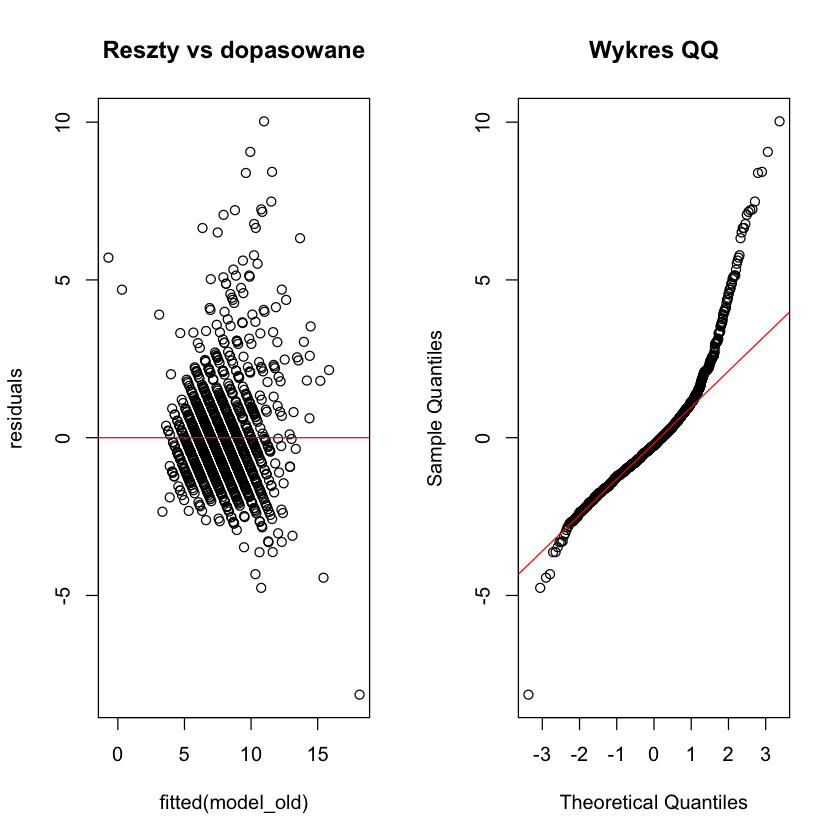

In [43]:
model_data <- cbind(X_old, Pierścienie = y_local$Pierścienie)
model_old <- lm(Pierścienie ~ ., data = model_data)

# Diagnostyka
residuals <- residuals(model_old)

par(mfrow = c(1,2))
plot(fitted(model_old), residuals, main = "Reszty vs dopasowane")
abline(h = 0, col = "red")
qqnorm(residuals, main = "Wykres QQ")
qqline(residuals, col = "red")

cat("Test Shapiro-Wilka p-value:", shapiro.test(residuals)$p.value, "\n")
cat("Test Breusch-Pagan p-value:", bptest(model_old)$p.value, "\n")

Normalność modelu

Redukcja nowych zmiennych 

In [44]:
# VIF dla modelu podstawowego
reduce_basic <- c('Cała_waga', 'Długość')
vifs_basic <- vifs_calculation(X_old, "Model bazowy")
print(vifs_basic)

# VIF po redukcji podstawowych zmiennych
vifs_basic_after_red <- vifs_calculation(dplyr::select(X_old, -all_of(reduce_basic)), "Model bazowy po redukcji")
print(vifs_basic_after_red)

# Tworzenie ostatecznego zbioru cech
X_final <- dplyr::select(X_new, -all_of(reduce_basic))

# Porównanie R-squared
model_new <- lm(Pierścienie ~ ., data = cbind(X_old, Pierścienie = y_local$Pierścienie))
model_final <- lm(Pierścienie ~ ., data = cbind(dplyr::select(X_old, -all_of(reduce_basic)), Pierścienie = y_local$Pierścienie))

cat("R-squared początkowy model:", summary(model_new)$r.squared, "\n")
cat("R-squared model po redukcji:", summary(model_final)$r.squared, "\n")

# Test F z permutacjami
n_perm <- 1000  # Liczba permutacji
F_test_before_reduction <- F_test_permutation(X_final, y_local$Pierścienie, NEW_FEATURE_NAMES, n_perm)
print(F_test_before_reduction)

# KOŃCOWA ANALIZA - VIFY PO REDUKCJI
significant_level <- 0.05
vif_reduce_value <- 10

F_test_before_reduction$`Odrzucenie H0` <- F_test_before_reduction$`P value` < significant_level
reduce_features_F_test <- rownames(F_test_before_reduction)[!F_test_before_reduction$`Odrzucenie H0`]

# Redukcja modelu na podstawie VIF
reduce_features_vif_test <- c()
vifs_after_F_test <- list()
index_name <- "Model rozszerzony przed redukcją vif"

repeat {
  drop_features <- c(reduce_features_F_test, reduce_features_vif_test)
  current_features <- setdiff(colnames(X_final), drop_features)
  local_vifs <- vifs_calculation(dplyr::select(X_final, all_of(current_features)), index_name)
  
  max_vif_column <- names(which.max(local_vifs[1, ]))
  max_vif_value <- max(local_vifs[1, ])
  
  vifs_after_F_test[[length(vifs_after_F_test) + 1]] <- local_vifs
  reduce_features_vif_test <- c(reduce_features_vif_test, max_vif_column)
  
  if (max_vif_value < vif_reduce_value) break
}

vifs_after_F_test <- dplyr::bind_rows(vifs_after_F_test)

# Porównanie modeli końcowych
model_new <- lm(Pierścienie ~ ., data = cbind(X_new, Pierścienie = y_local$Pierścienie))
model_final <- lm(Pierścienie ~ ., data = cbind(X_final, Pierścienie = y_local$Pierścienie))

cat("R-squared model pełny:", summary(model_new)$r.squared, "\n")
cat("R-squared model końcowy:", summary(model_final)$r.squared, "\n")

              Długość Średnica Wysokość Cała_waga Waga_po_obraniu Waga_trzewi
Model bazowy 37.54204 40.43951 7.504494  102.4888        23.21664    20.80902
             Waga_powłoki
Model bazowy     25.07552
                         Średnica Wysokość Waga_po_obraniu Waga_trzewi
Model bazowy po redukcji 10.06127 7.410882        9.093273     12.0225
                         Waga_powłoki
Model bazowy po redukcji     12.57993
R-squared początkowy model: 0.5894093 
R-squared model po redukcji: 0.5813639 
                             Statystyka F     P value
Długość/Wysokość                0.6866773 0.442557443
Masa/objętość                   7.3620233 0.004995005
Waga_powłoki/Cała_waga          2.8100485 0.084915085
Waga_po_obraniu/Cała_waga       1.8372126 0.145854146
Waga_trzewi/Cała_waga           1.9561303 0.172827173
Waga_powłoki/Waga_po_obraniu    5.4622358 0.023976024
Waga_trzewi/Waga_po_obraniu     2.4009378 0.115884116
Waga_trzewi/Waga_powłoki        0.0016408 0.979020979
R-squared